# Customer Cohort Analysis

Data source: [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx).

#### Project description:
Create customer cohorts based on purchase history. This will allow us to track their purchasing behavior, analyze the results and customize our strategies and offerings accordingly.

#### Content
1. Importing required libraries
2. Loading the data
3. Data Cleaning & Preperation
    1. Handling duplicates
    2. Handling missing values
    3. Handling returned orders
    4. Combining order line items
4. Cohort Analysis
    1. Creating customer & order cohorts
    2. Creating cohort dataframe
    3. Creating cohort matrix
    4. Building cohort generator function
    5. Exploring cohorts   

### 1. Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import operator as op # used for attrgetter function in time periods subtraction
import gc # to garbage collect
import warnings
warnings.filterwarnings("ignore")

In [2]:
# visualiztion settings
plt.style.use('ggplot')
sns.set(style='white')

### 2. Loading the data

In [3]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx'

columns_to_load = ['Invoice', 'StockCode', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']

# loading data
df1 = pd.read_excel(url, sheet_name='Year 2009-2010', usecols=columns_to_load, parse_dates=['InvoiceDate'])
df2 = pd.read_excel(url, sheet_name='Year 2010-2011', usecols=columns_to_load, parse_dates=['InvoiceDate'])

# concatenating dfs
df = pd.concat([df1, df2], axis=0)

# downcasting numbers
df[['Price', 'Customer ID']] = df[['Price', 'Customer ID']].apply(pd.to_numeric, downcast='float')
df['Quantity'] = df.Quantity.astype('int32')

# reseting index
df.reset_index(drop=True, inplace=True)

# renaming the columns
df.columns = ['invoice_id', 'stock_code', 'quantity', 'invoice_date', 'price', 'customer_id', 'country']

# dropping df1 and df2 for memory optimization
del df1
del df2
gc.collect()

# general info
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   invoice_id    1067371 non-null  object        
 1   stock_code    1067371 non-null  object        
 2   quantity      1067371 non-null  int32         
 3   invoice_date  1067371 non-null  datetime64[ns]
 4   price         1067371 non-null  float32       
 5   customer_id   824364 non-null   float32       
 6   country       1067371 non-null  object        
dtypes: datetime64[ns](1), float32(2), int32(1), object(3)
memory usage: 169.3 MB


In [4]:
# checking memory usage by each column in MB
df.memory_usage(deep=True).div(pow(1024, 2))

Index            0.000122
invoice_id      37.165981
stock_code      40.106495
quantity         4.071697
invoice_date     8.143394
price            4.071697
customer_id      4.071697
country         71.675744
dtype: float64

### 3. Data Cleaning & Preperation

In [5]:
# returning some df descreptives
def check_df(df):
    
    df_info = pd.DataFrame(columns=['column', 'dtype', 'count', 'nulls', 'min', 'max', 'smaple_value'])
    for col in df.columns:
        if df[col].dtype != object:
            df_info = df_info.append({'column':col, 'dtype':df[col].dtype, 'count':df[col].count(), 'nulls':df[col].isna().sum(), 'min':df[col].min(), 'max':df[col].max(), 'smaple_value':df[col][0]}, ignore_index=True)
        else:
            df_info = df_info.append({'column':col, 'dtype':df[col].dtype, 'count':df[col].count(), 'nulls':df[col].isna().sum(), 'min':np.nan, 'max':np.nan, 'smaple_value':df[col][0]}, ignore_index=True)


    return df_info

In [6]:
# checking df descreptives
check_df(df)

,column,dtype,count,nulls,min,max,smaple_value
0,invoice_id,object,1067371,0,NaN,NaN,489434
1,stock_code,object,1067371,0,NaN,NaN,85048
2,quantity,int32,1067371,0,-80995,80995,12
3,invoice_date,datetime64[ns],1067371,0,2009-12-01 07:45:00,2011-12-09 12:50:00,2009-12-01 07:45:00
4,price,float32,1067371,0,-53594.359375,38970.0,6.95
5,customer_id,float32,824364,243007,12346.0,18287.0,13085.0
6,country,object,1067371,0,NaN,NaN,United Kingdom


#### Handling duplicates

In [7]:
# check if there are any duplicate rows
df.duplicated().sum()

34337

In [8]:
# drop duplicates
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

#### Handling missing values

Since the purpose of our cohort analysis is to find pattern among customer cohorts over time, we will drop rows with no customer_id

In [9]:
df.dropna(subset=['customer_id'], inplace=True)
df.reset_index(drop=True, inplace=True)

#### Handling returned orders

We have negtives in quantity most likely due to returns. We do some analysis to learn more about them.

In [10]:
check_df(df)

,column,dtype,count,nulls,min,max,smaple_value
0,invoice_id,object,797883,0,NaN,NaN,489434
1,stock_code,object,797883,0,NaN,NaN,85048
2,quantity,int32,797883,0,-80995,80995,12
3,invoice_date,datetime64[ns],797883,0,2009-12-01 07:45:00,2011-12-09 12:50:00,2009-12-01 07:45:00
4,price,float32,797883,0,0.0,38970.0,6.95
5,customer_id,float32,797883,0,12346.0,18287.0,13085.0
6,country,object,797883,0,NaN,NaN,United Kingdom


In [11]:
# calculating the impact of returns on our dataset

# counting the returned item lines (rows)
line_item_returned = df.loc[df.quantity<0, 'quantity'].count()
# counting the returned item lines (rows) as the percentage of total rows excluding the returns
line_item_returned_percent = round(line_item_returned / df.loc[df.quantity>0, 'quantity'].count()*100, 3)

# counting the value of returned items
line_item_returned_value = -round(df.loc[df.quantity<0, 'price'].dot(df.loc[df.quantity<0, 'quantity']))
# counting the value of returned items as the percentage of total orders value excluding the returns
line_item_returned_value_percent = round(line_item_returned_value / df.loc[df.quantity>0, 'price'].dot(df.loc[df.quantity>0, 'quantity'])*100, 3)

# counting the number of orders with a returned item
returned_orders = df.loc[df.quantity<0, 'invoice_id'].nunique()
# counting the number of orders with a returned item as the percentage of total orders excluding the returns
returned_orders_percent = round(returned_orders / df.loc[df.quantity>0, 'invoice_id'].nunique()*100, 3)

dict={
    'line_item_returned': line_item_returned,
    'line_item_returned_percent': line_item_returned_percent,
    'line_item_returned_value': line_item_returned_value,
    'line_item_returned_value_percent': line_item_returned_value_percent,
    'returned_orders': returned_orders,
    'returned_orders_percent': returned_orders_percent
}

pd.Series(dict)

line_item_returned                    18390.000
line_item_returned_percent                2.359
line_item_returned_value            1084813.000
line_item_returned_value_percent          6.244
returned_orders                        7901.000
returned_orders_percent                  21.368
dtype: float64

To simplify our analysis, we will drop the returns which constitute 2.3% of rows and have a line item in 21% of orders.<br/>
This way, we avoid counting the returns as new orders and at the same time keeping the original orders as customer engagement with the company. However, we should keep in mind that this approach will inflate the revenue by 6%

In [12]:
# dropping returned item lines
df = df.loc[df.quantity>=0, :]
df.reset_index(drop=True, inplace=True)
check_df(df)

,column,dtype,count,nulls,min,max,smaple_value
0,invoice_id,object,779493,0,NaN,NaN,489434
1,stock_code,object,779493,0,NaN,NaN,85048
2,quantity,int32,779493,0,1,80995,12
3,invoice_date,datetime64[ns],779493,0,2009-12-01 07:45:00,2011-12-09 12:50:00,2009-12-01 07:45:00
4,price,float32,779493,0,0.0,10953.5,6.95
5,customer_id,float32,779493,0,12346.0,18287.0,13085.0
6,country,object,779493,0,NaN,NaN,United Kingdom


In [13]:
# changing the column type to reduce the file size and memory usage
df['invoice_id'] = df.invoice_id.astype('int32')
df.reset_index(drop=True, inplace=True)
df.memory_usage(deep=True).div(pow(1024, 2))

Index            0.000122
invoice_id       2.973530
stock_code      29.042968
quantity         2.973530
invoice_date     5.947060
price            2.973530
customer_id      2.973530
country         52.233520
dtype: float64

In [14]:
df.head()

,invoice_id,stock_code,quantity,invoice_date,price,customer_id,country
0,489434,85048,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


#### Combining order line items

In [15]:
# calculating order value per item line
df['order_value'] = df['quantity'].mul(df['price'])

# combining orders per customer per date
df_orders = df.groupby(['customer_id', 'invoice_date', 'invoice_id']).agg({'order_value':'sum', 'quantity': 'sum', 'stock_code':'count','country': 'first'}).reset_index().rename(columns={'quantity': 'items_count', 'stock_code': 'sku_count'})
df_orders['order_value'] = df_orders['order_value'].round(2)

df_orders.head()

,customer_id,invoice_date,invoice_id,order_value,items_count,sku_count,country
0,12346.0,2009-12-14 08:34:00,491725,45.0,10,1,United Kingdom
1,12346.0,2009-12-14 11:00:00,491742,22.5,5,1,United Kingdom
2,12346.0,2009-12-14 11:02:00,491744,22.5,5,1,United Kingdom
3,12346.0,2009-12-18 10:47:00,492718,22.5,5,1,United Kingdom
4,12346.0,2009-12-18 10:55:00,492722,1.0,1,1,United Kingdom


In [16]:
# Now, we can work with a much smaller file size
df_orders.memory_usage(deep=True).div(pow(1024, 2))

Index           0.000122
customer_id     0.282585
invoice_date    0.282585
invoice_id      0.282585
order_value     0.282585
items_count     0.141293
sku_count       0.282585
country         2.484160
dtype: float64

In [17]:
# we have a few orders with large number of items and SKUs
check_df(df_orders)

,column,dtype,count,nulls,min,max,smaple_value
0,customer_id,float64,37039,0,12346.0,18287.0,12346.0
1,invoice_date,datetime64[ns],37039,0,2009-12-01 07:45:00,2011-12-09 12:50:00,2009-12-14 08:34:00
2,invoice_id,int64,37039,0,489434,581587,491725
3,order_value,float64,37039,0,0.0,168469.59,45.0
4,items_count,int32,37039,0,1,87167,10
5,sku_count,int64,37039,0,1,542,1
6,country,object,37039,0,NaN,NaN,United Kingdom


In [18]:
# we don't need df anymore, so we drop it
del df
gc.collect()

48

In [19]:
# exporting the clean dataset to be used in other projects
df_orders.to_csv('.\df_orders.csv', index=False)

#### Quick look at the data

Purchase frequency for the whole dataset is 6.29% and only 28% of customers were one time shppers which indicates a relatively high retention rate for the business 

Purchase frequency: 6.29%
Percentage of customers ordered more than once: 72.35%


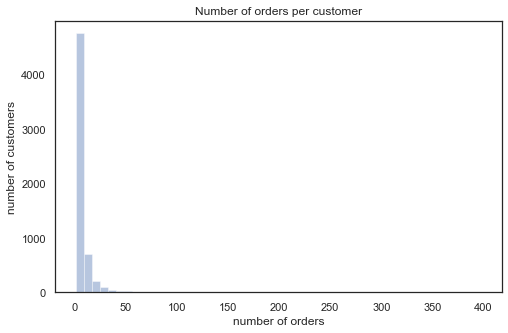

In [20]:
# average purchase frequency for the dataset
avg_purchase_frequency = round(df_orders['invoice_id'].nunique()/df_orders['customer_id'].nunique(), 2)

# Percentage of customers ordered more than once
orders_per_customer = df_orders.groupby(['customer_id'])['invoice_id'].nunique()
over_one_order_percent = round(sum(orders_per_customer> 1)/df_orders['customer_id'].nunique() * 100, 2)

print(f'Purchase frequency: {avg_purchase_frequency}%\nPercentage of customers ordered more than once: {over_one_order_percent}%')

# plotting the distribution of number of orders by customer count
plt.figure(figsize=(8, 5))
ax = sns.distplot(orders_per_customer, kde=False)
ax.set(xlabel='number of orders', ylabel='number of customers', title='Number of orders per customer')
plt.show()

In [21]:
df_orders.head()

,customer_id,invoice_date,invoice_id,order_value,items_count,sku_count,country
0,12346.0,2009-12-14 08:34:00,491725,45.0,10,1,United Kingdom
1,12346.0,2009-12-14 11:00:00,491742,22.5,5,1,United Kingdom
2,12346.0,2009-12-14 11:02:00,491744,22.5,5,1,United Kingdom
3,12346.0,2009-12-18 10:47:00,492718,22.5,5,1,United Kingdom
4,12346.0,2009-12-18 10:55:00,492722,1.0,1,1,United Kingdom


### 4. Cohort Analysis

#### Creating customer & order cohorts

We create customer cohort based on the date of first order placed by each customer.<br/>
Order cohort is simply the invoice_date transformed to the time period defined when creating the customer cohort (cohort size). It allows to track each order placed by customer over time.

In [22]:
# making a copy of transactional df
df_cohort_prep = df_orders.copy()

# creating customer cohort
df_cohort_prep['customer_cohort'] = df_cohort_prep.groupby('customer_id')['invoice_date'].transform('min').dt.to_period('M')
# creating order cohort
df_cohort_prep['order_cohort'] = df_cohort_prep['invoice_date'].dt.to_period('M')
df_cohort_prep.head()

,customer_id,invoice_date,invoice_id,order_value,items_count,sku_count,country,customer_cohort,order_cohort
0,12346.0,2009-12-14 08:34:00,491725,45.0,10,1,United Kingdom,2009-12,2009-12
1,12346.0,2009-12-14 11:00:00,491742,22.5,5,1,United Kingdom,2009-12,2009-12
2,12346.0,2009-12-14 11:02:00,491744,22.5,5,1,United Kingdom,2009-12,2009-12
3,12346.0,2009-12-18 10:47:00,492718,22.5,5,1,United Kingdom,2009-12,2009-12
4,12346.0,2009-12-18 10:55:00,492722,1.0,1,1,United Kingdom,2009-12,2009-12


#### Creating cohort dataframe

First, we group the data by 'customer_cohort' and 'order_cohort' to calculate differnt metrics for each combinantion.

In [23]:
# creating cohort df
df_cohort = df_cohort_prep.groupby(['customer_cohort', 'order_cohort'])[
    ['customer_id', 'invoice_id', 'order_value', 'items_count', 'sku_count', 'country']
    ].agg(
        customers = ('customer_id', 'nunique'),
        orders = ('invoice_id', 'nunique'),
        orders_value = ('order_value', 'sum'),
        orders_items = ('items_count', 'sum'),
        orders_skus = ('sku_count', 'sum'),
        orders_countries = ('country', 'nunique')
    ).reset_index()

# creating periods column which is the number of periods between the customer cohort and the order cohort (the time when the orders were placed)
df_cohort['periods'] = df_cohort.order_cohort.sub(df_cohort.customer_cohort).apply(op.attrgetter('n'))

# calculating different metrics for each 'customer_cohort' and 'order_cohort' combination
df_cohort['orders_value'] = df_cohort['orders_value'].round(0)
df_cohort['aov'] = df_cohort.orders_value.div(df_cohort.orders).round(0)
df_cohort['avg_order_items'] = df_cohort.orders_items.div(df_cohort.orders).round(0)
df_cohort['avg_order_skus'] = df_cohort.orders_skus.div(df_cohort.orders).round(0)

df_cohort.head().T

,0,1,2,3,4
customer_cohort,2009-12,2009-12,2009-12,2009-12,2009-12
order_cohort,2009-12,2010-01,2010-02,2010-03,2010-04
customers,955,337,319,406,363
orders,1512,569,564,717,629
orders_value,683504.0,394724.0,295932.0,378663.0,305901.0
orders_items,398708,277938,247565,322262,172033
orders_skus,30279,11904,11451,14229,12636
orders_countries,22,10,9,13,10
periods,0,1,2,3,4
aov,452.0,694.0,525.0,528.0,486.0


#### Creating cohort matrix

Now, from cohort df, we can create a matrix where the index is the customer cohort and the columns are the periods. Then we populate the matrix with the aggregate values of the required metrics.

In [24]:
# creating the cohort matrix
df_cohort_matrix = df_cohort.pivot_table(index='customer_cohort', columns='periods', values='customers', fill_value=0)
df_cohort_matrix.head()

periods,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
customer_cohort,,,,,,,,,,,,,,,,,,,,,
2009-12,955,337,319,406,363,343,360,327,321,346,...,289,251,289,270,248,244,301,291,389,188
2010-01,383,79,119,117,101,115,99,88,107,122,...,58,90,76,71,75,93,74,94,22,0
2010-02,376,89,84,109,92,75,72,107,95,103,...,75,60,61,54,86,86,61,22,0,0
2010-03,443,84,102,107,103,90,109,134,122,48,...,75,77,69,78,89,94,35,0,0,0
2010-04,294,57,57,48,54,66,81,77,31,32,...,46,41,44,53,66,17,0,0,0,0


In [25]:
# creating the cohort matrix percentage
# this matrix allows us to see future periods performance as a percentage of period 0 for each cohort
df_cohort_matrix_percent = df_cohort_matrix.div(df_cohort_matrix.iloc[:, 0], axis=0).mul(100).round(2)
df_cohort_matrix_percent.head()

periods,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
customer_cohort,,,,,,,,,,,,,,,,,,,,,
2009-12,100.0,35.29,33.40,42.51,38.01,35.92,37.70,34.24,33.61,36.23,...,30.26,26.28,30.26,28.27,25.97,25.55,31.52,30.47,40.73,19.69
2010-01,100.0,20.63,31.07,30.55,26.37,30.03,25.85,22.98,27.94,31.85,...,15.14,23.50,19.84,18.54,19.58,24.28,19.32,24.54,5.74,0.00
2010-02,100.0,23.67,22.34,28.99,24.47,19.95,19.15,28.46,25.27,27.39,...,19.95,15.96,16.22,14.36,22.87,22.87,16.22,5.85,0.00,0.00
2010-03,100.0,18.96,23.02,24.15,23.25,20.32,24.60,30.25,27.54,10.84,...,16.93,17.38,15.58,17.61,20.09,21.22,7.90,0.00,0.00,0.00
2010-04,100.0,19.39,19.39,16.33,18.37,22.45,27.55,26.19,10.54,10.88,...,15.65,13.95,14.97,18.03,22.45,5.78,0.00,0.00,0.00,0.00


#### Building cohort generator function

Now that we know all the steps to create the cohort matrix, we create a function to accept a transactional df, cohort size(time period) and the metric to calculate the above created matrix for us in one step.

In [26]:
# 
def create_cohort_matrix(df, cohort_size, metric, percent, plot=True):

    # creating customer cohort
    df['customer_cohort'] = df.groupby('customer_id')['invoice_date'].transform('min').dt.to_period(cohort_size)
    # creating order cohort
    df['order_cohort'] = df['invoice_date'].dt.to_period(cohort_size)

    # creating cohort df
    cohort = df.groupby(['customer_cohort', 'order_cohort'])[
        ['customer_id', 'invoice_id', 'order_value', 'items_count', 'sku_count', 'country']
        ].agg(
            customers = ('customer_id', 'nunique'),
            orders = ('invoice_id', 'nunique'),
            orders_value = ('order_value', 'sum'),
            orders_items = ('items_count', 'sum'),
            orders_skus = ('sku_count', 'sum'),
            orders_countries = ('country', 'nunique')
        ).reset_index()

    # creating periods column which is the number of periods between the customer cohort and the order cohort (the time when the orders were placed)
    cohort['periods'] = cohort.order_cohort.sub(cohort.customer_cohort).apply(op.attrgetter('n'))

    # calculating different metrics for each 'customer_cohort' and 'order_cohort' combination
    cohort['orders_value'] = cohort['orders_value'].round(0)
    cohort['aov'] = cohort.orders_value.div(cohort.orders).round(0)
    cohort['avg_order_items'] = cohort.orders_items.div(cohort.orders).round(0)
    cohort['avg_order_skus'] = cohort.orders_skus.div(cohort.orders).round(0)

    # creating the cohort matrix with metric being the column we want to see values for aggregation
    cohort_matrix = cohort.pivot_table(index='customer_cohort', columns='periods', values=metric, fill_value=0)

    if percent:
        # creating the cohort matrix percentage
        # this matrix allows us to see future periods performance as a percentage of period 0 for each cohort
        cohort_matrix = cohort_matrix.div(cohort_matrix.iloc[:, 0], axis=0).mul(100).round(2)

    def plot_cohort_matrix(cohort_matrix, cohort_size, metric, percent):

        if cohort_size=='W':
            c_size='Weekly'
            size='Week'
        if cohort_size=='M':
            c_size='Monthly'
            size='Month'
        if cohort_size=='Q':
            c_size='Quarterly'
            size='Quarter'
        if cohort_size=='A':
            c_size='Annualy'
            size='Year'

        metric = metric.title().replace('_', ' ')

        # plot a heatmap for cohort_matrix
        num_annotate = cohort_matrix[cohort_matrix != 0]

        fig, ax = plt.subplots(figsize=(22, 8))

        cohort_matrix_heatmap = sns.heatmap(cohort_matrix, 
                                            annot=num_annotate, 
                                            mask=num_annotate.isna(),
                                            linewidths=2,
                                            fmt='.0f', 
                                            cmap='Blues', 
                                            ax=ax)

        if percent:
            ax.axes.set_title(f'{c_size} {metric} As % Of First {size} {metric} Per Cohort',fontsize=20)
        else:
            ax.axes.set_title(f'{c_size} {metric} Per Cohort',fontsize=20)
        
        ax.set_xlabel('Periods', fontsize=16)
        ax.set_ylabel('Customer Cohort', fontsize=16)
        plt.show()

    if plot:
        return plot_cohort_matrix(cohort_matrix, cohort_size, metric, percent)

    return cohort_matrix

#### Exploring cohorts

Quick look at the cohorts

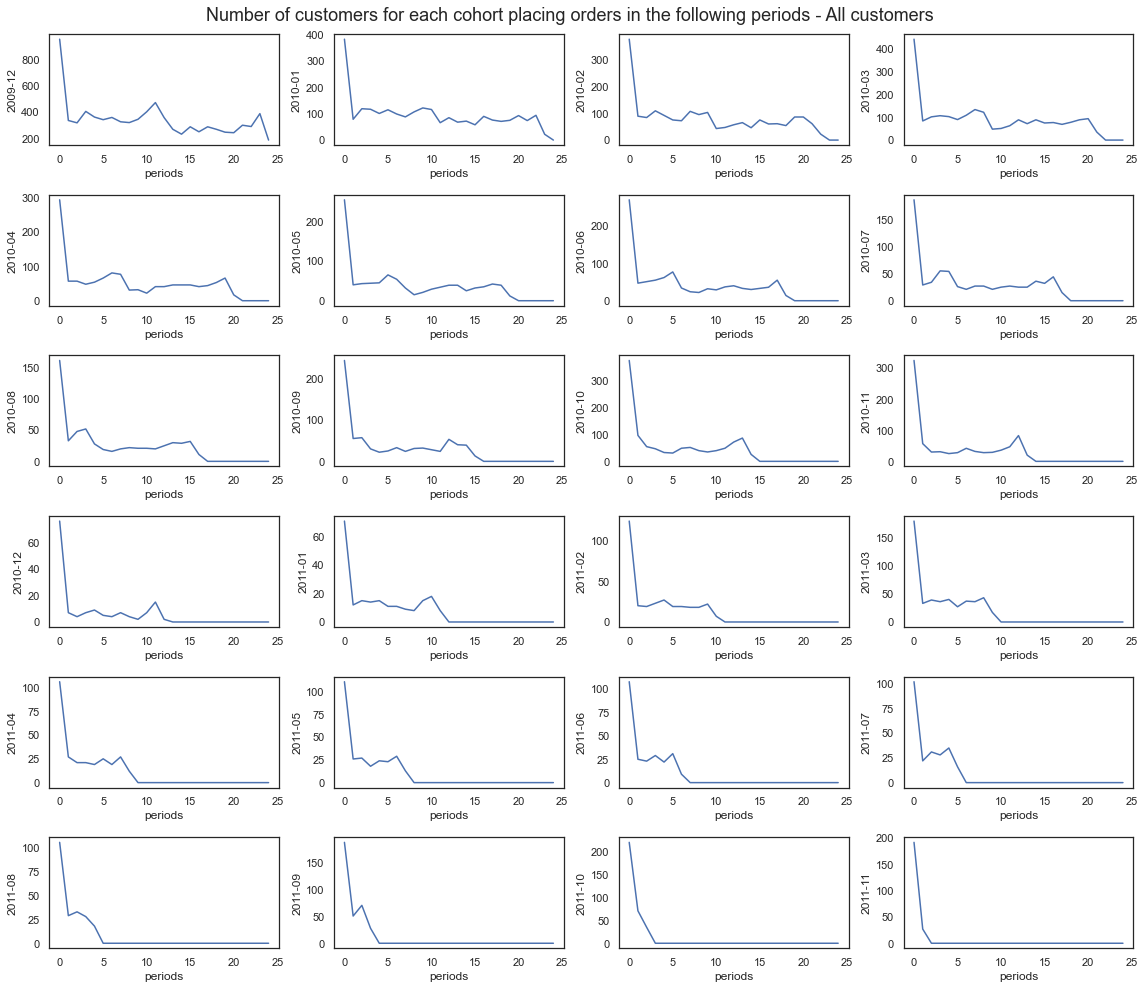

In [27]:
# creating a chart for all customers for all the cohorts 

df_matrix = create_cohort_matrix(df_orders, cohort_size='M', metric='customers', percent=False, plot=False)

fig, axs = plt.subplots(6, 4, figsize=(16, 14))

for i, ax in zip(df_matrix.columns, axs.ravel()):
    sns.lineplot(x=df_matrix.columns, y=df_matrix.iloc[i, :], ax=ax)

plt.suptitle('Number of customers for each cohort placing orders in the following periods - All customers', fontsize=18)
plt.tight_layout()
plt.show()

Customers aquired in December 2009 are by far the most engaged customers with higher repeat purchase rate.

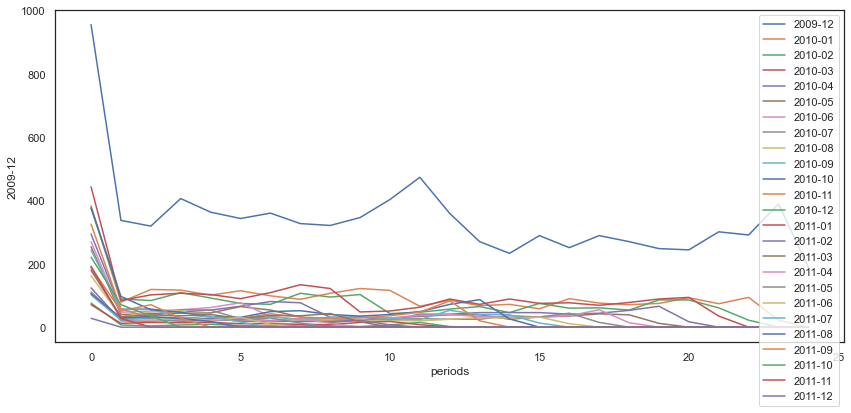

In [28]:
# creating a line chart for all customers in all the cohorts 

df_matrix = create_cohort_matrix(df_orders, cohort_size='M', metric='customers', percent=False, plot=False)

fig, axs = plt.subplots(figsize=(12, 6))

for i in range(len(df_matrix)):
    sns.lineplot(x=df_matrix.columns, y=df_matrix.iloc[i, :], label=df_matrix.index[i])

plt.legend()
plt.tight_layout()
plt.show()

##### Customer retention & engagement

NOTE: Q4 of 2009 only includes Decemeber

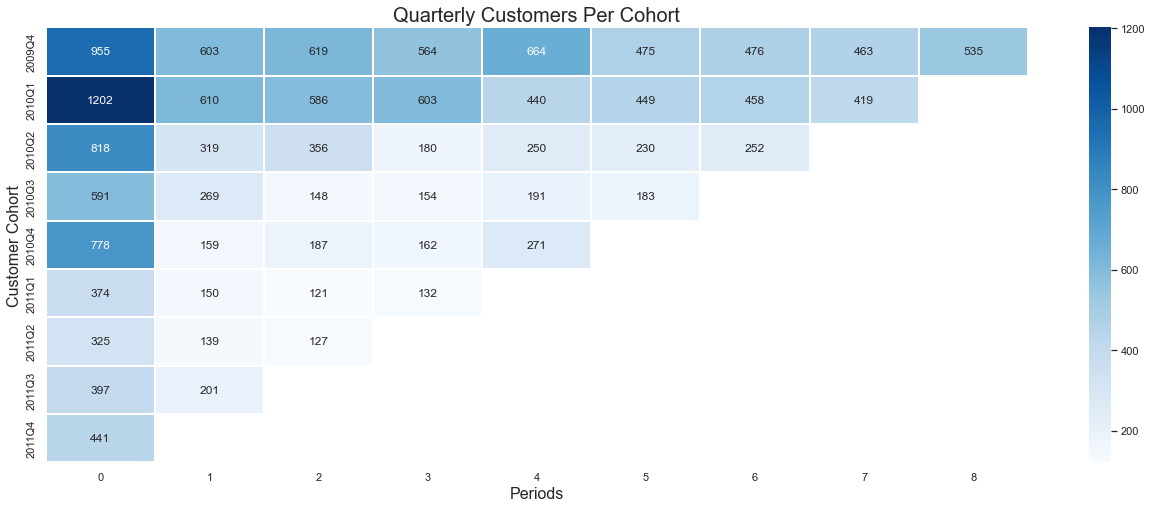

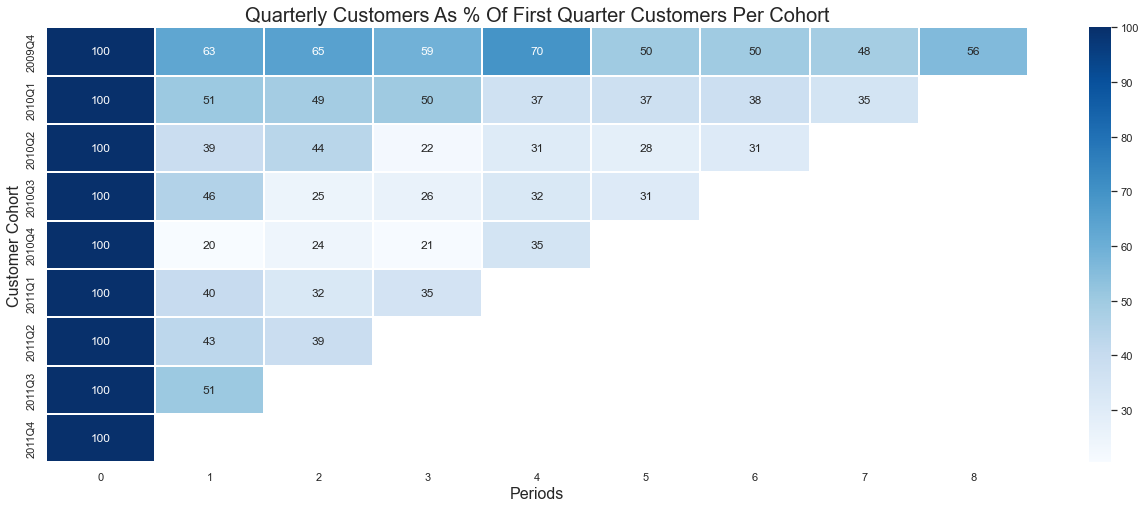

In [29]:
create_cohort_matrix(df_orders, cohort_size='Q', metric='customers', percent=False, plot=True)
create_cohort_matrix(df_orders, cohort_size='Q', metric='customers', percent=True, plot=True)

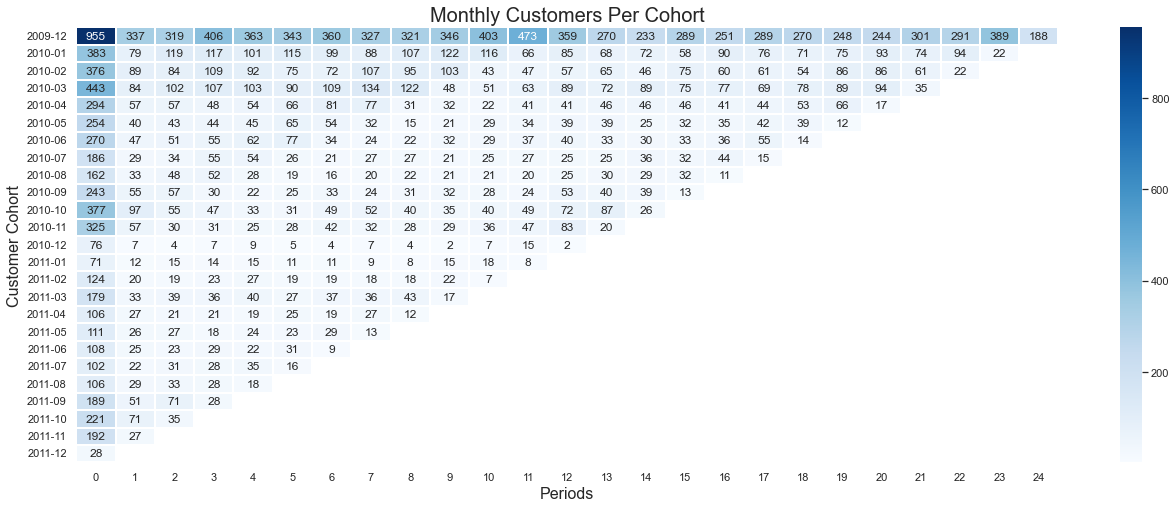

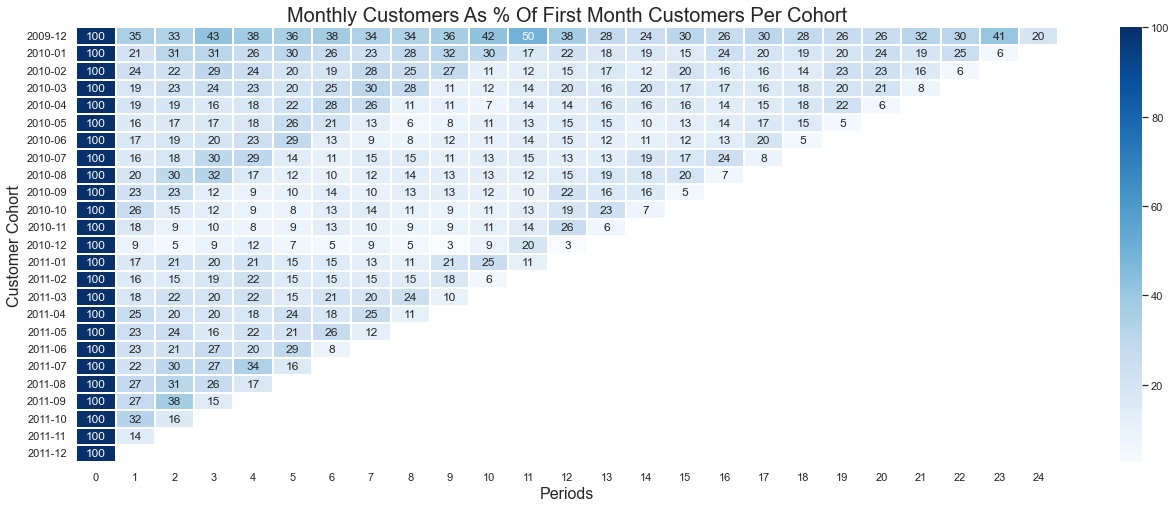

In [30]:
create_cohort_matrix(df_orders, cohort_size='M', metric='customers', percent=False, plot=True)
create_cohort_matrix(df_orders, cohort_size='M', metric='customers', percent=True, plot=True)

##### 

Using cohort analysis functions, we can explore our data based on the cohorts to get more insights form different aspects.<br/>
For example, the below graph shows the moajority of customers in each cohort are from UK.

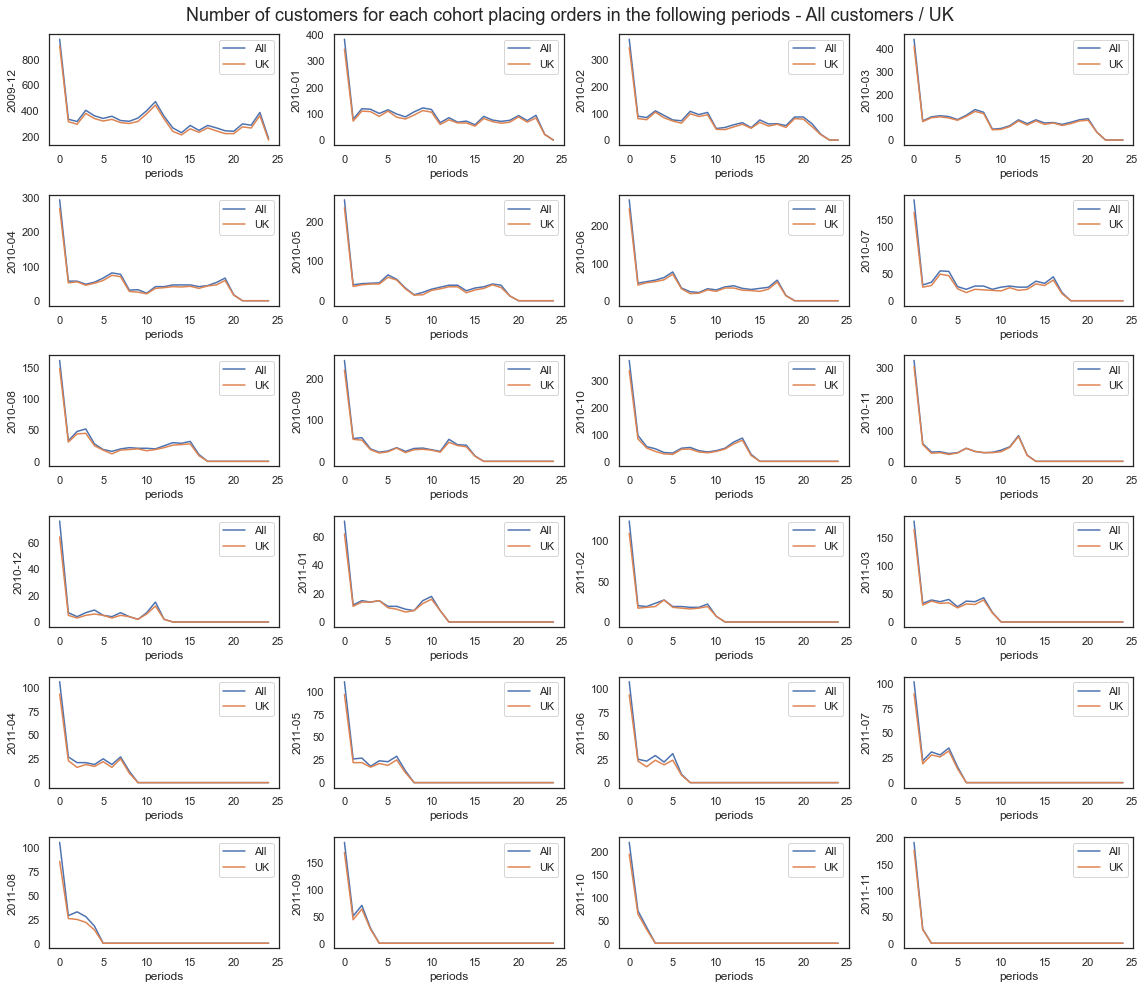

In [31]:
# creating a chart for all customers and customers from UK for all the cohorts 

df_matrix = create_cohort_matrix(df_orders, cohort_size='M', metric='customers', percent=False, plot=False)
df_matrix_uk = create_cohort_matrix(df_orders.loc[df_orders.country == 'United Kingdom', :], cohort_size='M', metric='customers', percent=False, plot=False)

fig, axs = plt.subplots(6, 4, figsize=(16, 14))

for i, ax in zip(df_matrix.columns, axs.ravel()):
    sns.lineplot(x=df_matrix.columns, y=df_matrix.iloc[i, :], ax=ax, label='All')
    sns.lineplot(x=df_matrix_uk.columns, y=df_matrix_uk.iloc[i, :], ax=ax, label='UK')

plt.suptitle('Number of customers for each cohort placing orders in the following periods - All customers / UK', fontsize=18)
plt.legend()
plt.tight_layout()
plt.show()